# ASTR 596 Fall 2023 - Surface photometry lab (50 Points)
In this lab we will be performing surface photometry of two nearby galaxies, an elliptical and a spiral.  

This lab will be done via a mixture of python commands using the photutils aperture photometry package (https://photutils.readthedocs.io/en/stable/aperture.html) and the photutils isophote fitting package (https://photutils.readthedocs.io/en/stable/isophote.html).  We will also be using imexam and ds9.

In this lab you will learn how to do the following things:
* estimate the background for an image and subtract it;
* estimate initial guesses for input parameters to an isophotal fitting code using ds9;
* fit elliptical isophotes;
* use photometry within these isophotes to measure the radial profile of various parameters;
* compute the radius within which half the total light is contained.  This is called the effective radius.

<i>Note: Enter in all code to the problems in the provided notebook cells. Questions to answer will be <b>bolded</b>.</i>  

All your answers should be entered in this notebook. Each student will need to hand in their own notebook by uploading it to GitHub following the instructions.

In the code places where you will need to put something or write your own code are specified by `#***************`  You will not get points for doing this unless explicitly noted.  Some of these things are just to make sure you are setting up your paths correctly.

**Due on <font color='red'>11/20 at Noon</font>** to be handed into the "Surface Photometry" assignment in <font color='red'>Module 7</font>.

You will need to download the raw data from https://www.dropbox.com/t/9JMlIMfRblkfGiAY.  There are four galaxy images.  You will need to measure something from all of them.  The galaxies are:
* NGC 3982
* NGC 5198
* NGC 5985
* PCG 0997820

I suggest you make a directory on your computer called `~/ASTR596/Data` and put data in there in a directory you name that is specific to this assignment.  

In [1]:
#import 
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.io import fits
import glob
import os
from scipy.stats import scoreatpercentile
import astropy.units as u
from scipy import stats

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import colors


from astropy.nddata import CCDData
#from ccdproc import ImageFileCollection, Combiner, combine
from ccdproc import wcs_project

### Some functions to display the images and overplot the stars

In [2]:
def imdisplay(image, v1perc=10, v2perc=95, logscale=True):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    print(v1,v2)
    if (logscale):
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
    else:
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')
        
    cbar = fig.colorbar(im, ax=ax, fraction=0.04)
    cbar.ax.set_ylabel('counts')
    return fig,ax
    #fig.colorbar(fraction=.08)

In [3]:
#***************
#put your data directory here
datadir = '/home/d420h138/ASTR596/Data/Surface_Photometry'
os.chdir(datadir)

## Display the image in DS9

SAOimage DS9 is a popular and easy to use image viewer.  There are various tutorials at https://sites.google.com/cfa.harvard.edu/saoimageds9/documentation?authuser=0 .

Here is another third party tutorial https://astrobites.org/2011/03/09/how-to-use-sao-ds9-to-examine-astronomical-images/ 

In the following description I will refer to menu choices as those at the top of the screen or window.  I will refer to buttons as the double line of buttons right above where the image is displayed.  I will refer to sub buttons with **button1**->**button2**

1. In DS9 open `NGC3982-custom-image-r.fits`
2. Under the **scale** button choose **log** and **zscale**.  In the Menu bar choose Scale->Scale parameters.  In the "high" box choose 3.
3. Use the right mouse button to change the stretch on the image.  You may need to select the **edit**->**none** or **edit**->**colorbar** button for this to work.


## Problem 1 - Estimate the background and subtract it (5 Points)

Before performing photometry you need to subtract off the background.  To do this for this exercise you are going to:
1. pick a square region in each of the 4 corners of the image and compute the best estimate of the background level over all the pixels in these areas.  Note that the straight average may not be the best option.
2. subtract this background level from the image 
3. display the background subtracted image

#### 1. compute background level
Here is an example of how to display an image with a log scaling.

10.19071102142334 11.842433891296398


Text(0.5, 1.0, 'NGC3982-custom-image-r.bkg.fits')

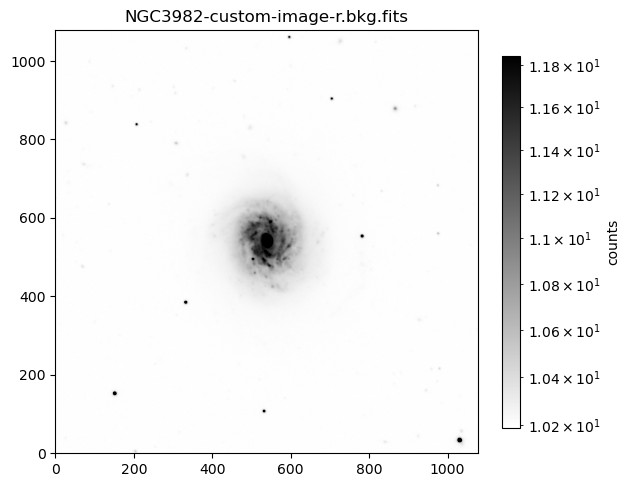

In [4]:
imname = 'NGC3982-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))
data,header = fits.getdata(imname, header=True)
imdisplay(data,v1perc=1,v2perc=99.9,logscale=True)

plt.title(imname)

This is a code that will take in an image name and data, as well as corners of background boxes, and will measure the background in two different ways.

In [5]:
def background_meas(imname,data,header,fig,ax,corners,bkg_size=5):
    #need to find ways to select regions of pixels in image
    imdisplay(data,v1perc=1,v2perc=99,logscale=True)

    plt.title(imname)

    #print out the x and y-dimension of the image using the header keywords
    print('image xdim = ', header['NAXIS1'], '; image ydim = ',header['NAXIS2'])
    #the length of each background box size
    #bkg_size = 200

    #make an array whose elements are the different data sections.
    reg = np.array([])


    #specify the different regions.  Each will be appended to the reg array.  the reg array is therefore 3 dimensional.  
    #the first dimension is for each region.  Each of those dimensions contains a 2D array that holds the image section.
    reg = np.append(reg, data[corners[0][0]:bkg_size-1, corners[0][1]:bkg_size-1])    #lower left corner
    reg = np.append(reg, data[corners[1][0]:bkg_size-1, corners[1][1]:])    #upper left corner
    reg = np.append(reg, data[corners[2][0]:, corners[2][1]:])    #upper right corner
    reg = np.append(reg, data[corners[3][0]:, corners[3][1]:bkg_size-1])   #lower right corner

    #print the median and mode of all the pixels. 
    bkgmode =stats.mode(reg,keepdims=False)[0]
    bkgmed = np.median(reg)
    print('mode = ',bkgmode)
    print('median = ',bkgmed)

    #Overlay rectangles with the background region indicated
    rectlist = []
    #loop through all images 
    for corn in corners:
        rect = plt.Rectangle((corn),bkg_size, bkg_size,linewidth=2,angle=0.0)
        rectlist.append(rect)
        pc = PatchCollection(rectlist,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_collection(pc)
        
    return bkgmode,bkgmed


Open the image in ds9 and use the log stretch to see if you can define corners of the image that are relatively free of galaxy light at a hard stretch.  You will compute the average pixel value in each of these regions and take the average.  It is ok if there are stars in these regions.  You should have 4 regions for the image.  An example that works for this image is shown below.  

**Note**
* to make it simpler, the boxes should be equal in size.  You will need to specify the lower left corner of each box.
* The images I am providing here have been selected from much larger images from the DESI Legacy Survey https://www.legacysurvey.org/viewer .  Therefore they do not have strange behavior around the edges and you can use the edges of the image as the edges of your sky region without any buffer region.

To make your coding easier, I'm going to make a bunch of dictionaries such that the main variable name is the same and you only have to change the galaxy name with the galname variable.

In [6]:
#initialize dictionaries that contains names of images and headers
imname = {}
data = {}
header = {}
corners = {}
bkgdim = {}

#statistics of background
bkgmode = {}
bkgmed = {}

In [7]:
#a routine to plot the images with the background measurement corners shown in red
def bkgregplot(data,header,imname, bkgdim, fig, ax):
    #define lower-left corners of each region
    corners = []
    corners.append([0,0])
    corners.append([0,header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim, header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim,0])

    #run the background_meas code to measure the background and plot the background regions
    bkgmode,bkgmed = background_meas(imname, data, header, fig, ax, 
                                                       corners,bkg_size=bkgdim)
    return bkgmode, bkgmed

### NGC3982

10.19071102142334 10.892627716064453
image xdim =  1079 ; image ydim =  1079
mode =  10.20165729522705
median =  10.200187683105469


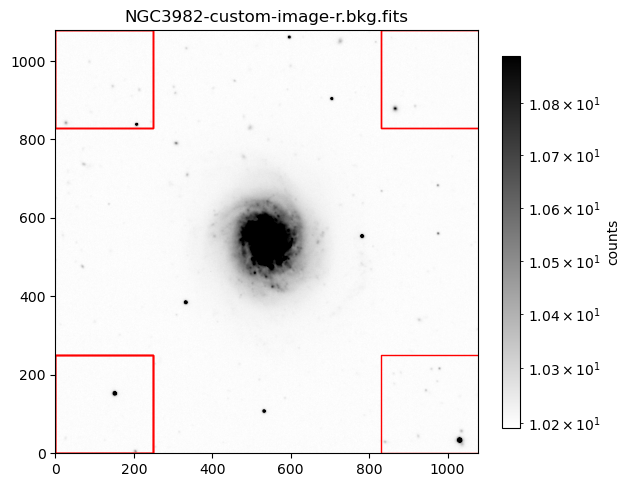

In [8]:
galname = 'NGC3982'
imname[galname] = 'NGC3982-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
bkgdim[galname]= 250

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)


### NGC5198

5.3430326461792 5.763217258453368
image xdim =  1131 ; image ydim =  1131
mode =  5.350897789001465
median =  5.34993314743042


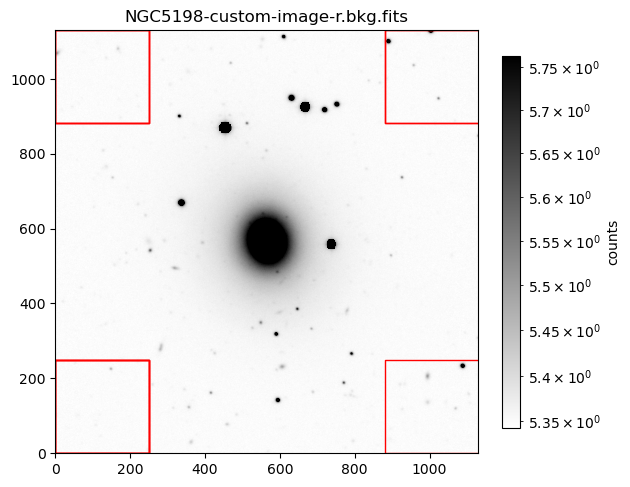

In [9]:
#*******************
#write your code here
galname = 'NGC5198'
imname[galname] = 'NGC5198-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
bkgdim[galname]= 250

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

### NGC5985

22.116252899169922 22.362007522583006
image xdim =  2291 ; image ydim =  2291
mode =  22.12332534790039
median =  22.122892379760742


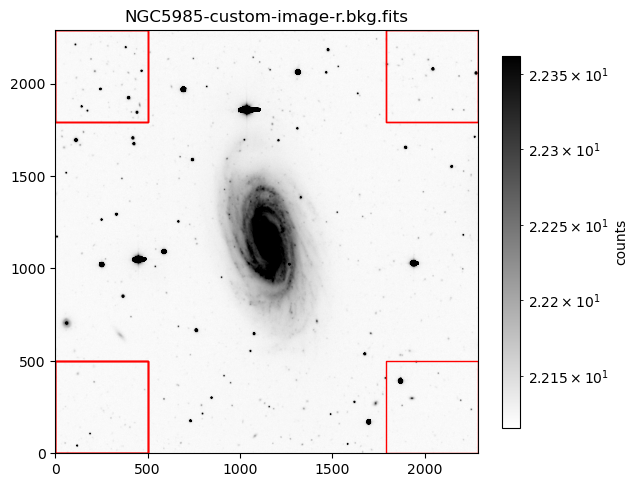

In [11]:
#*******************
#write your code here
galname = 'NGC5985'
imname[galname] = 'NGC5985-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
bkgdim[galname]= 500

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

### PCG0997820

5.341621627807617 5.481662235260011
image xdim =  403 ; image ydim =  403
mode =  5.351508617401123
median =  5.350394248962402


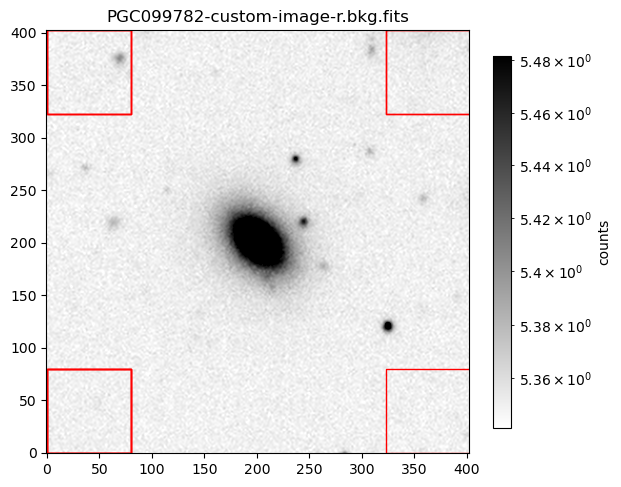

In [12]:
#*******************
#write your code here
galname = 'PGC099782'
imname[galname] = 'PGC099782-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
bkgdim[galname]= 80

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

#### 2. subtract background and display subtracted image

In this component you will need to:
* subtract your background from the previously read in image
* display that image
* write out your image

I provide one example below and you will need to do the other 3.  Note that since counts can be negative, you will need to choose v1perc to make sure that the lowest counts are positive.  The limits of the colorbar scale are printed after the imdisplay() command so you will see how far you are away.

In [13]:
#initializse dictionary that will hold background subtracted images
data_bsub = {}
imname_bsub = {}

### NGC 3982

0.00010395050048828125 1.6422462081909286


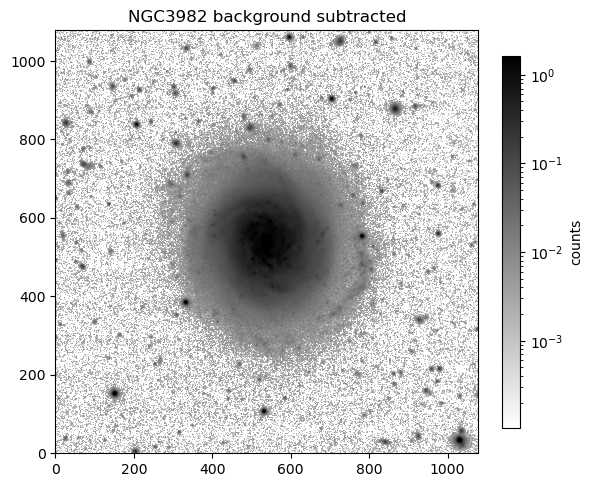

In [14]:
galname = 'NGC3982'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### NGC 5198

0.0009398460388183594 10.000036239624023


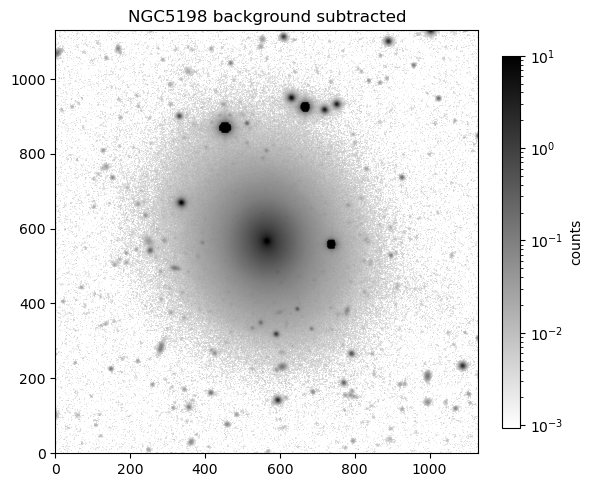

In [15]:
#***************
#your code goes here
galname = 'NGC5198'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### NGC 5985

0.0002899169921875 10.000089645385742


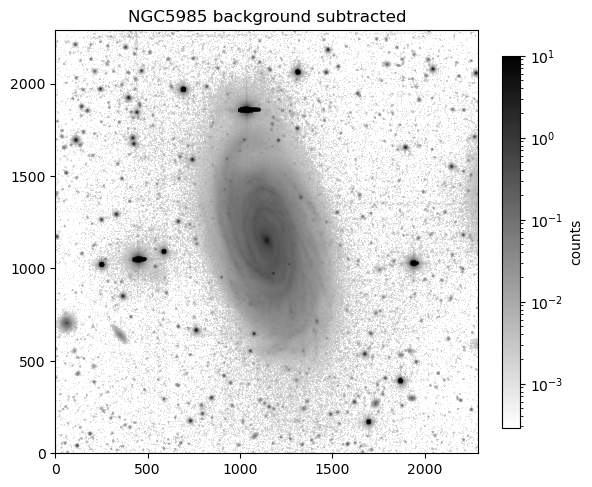

In [16]:
#***************
#your code goes here
galname = 'NGC5985'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### PGC 0997820

0.0004949569702148438 0.6742499732971232


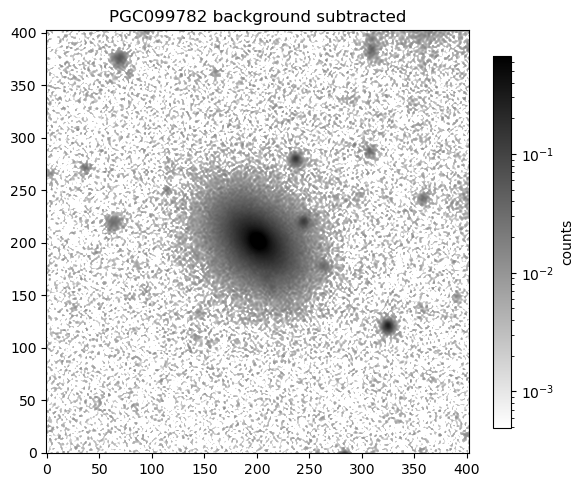

In [18]:
#***************
#your code goes here
galname = 'PGC099782'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=50,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

**Question**: comment on the differences between the images with background and those with background subtracted.  Please describe why you think this is.

put answer here.

The galaxies are a lot more prominent against the background now. Which makes sense because we subtracted the average background noise from the overall image. But the stars are also a lot more prominent as well.

## Problem 2 - estimate initial guesses for ellipse parameters (15 Points)
The `photutils` package that we will be using for doing our photometry requires initial guesses for the center, semi-major axis, ellipticity, and position angle.  We will measure these using DS9.  
* xcen, ycen: What you think the center is by using the cursor on ds9

* semi-major axis, ellipticity, PA: For the other items you will need to make an elliptical region in ds9 that matches where the brighter part of the galaxy is.  If you double click on the region it will bring up a dialog box that lets you adjust the PA and also will output the semi-major and semi-minor axes, which you will need for the ellipticity measurement.  You should display the information in pixels using the dropdown to the right of the `radius` field in the "Ellipse" window.  Choose `Image`

**Note**: In ds9, when the first radius in the `Ellipse` window is the semi-major axis, the PA is measured South of East.  This is the same sense as the Elliptical Isophote package in the following problem uses.

For each galaxy, provide these intial guesses.  I will be storing these as a python dictionary for each galaxy.

These guesses do not need to be super precise but they need to be in the right ballpark.

In [19]:
#initialize the dictionary containing the intial parameters for the ellipse fitting
initparams = {}

#### NGC 3982

In [23]:
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC3982'
initparams[galname] = {}
initparams[galname]['xcen'] = 541
initparams[galname]['ycen'] = 541
initparams[galname]['sma'] = 96
initparams[galname]['ellip'] = 96./116.
initparams[galname]['PA'] = 90.0

#### NGC 5198

In [25]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5198'
initparams[galname] = {}
initparams[galname]['xcen'] = 565
initparams[galname]['ycen'] = 565
initparams[galname]['sma'] = 123
initparams[galname]['ellip'] = 106/123
initparams[galname]['PA'] = -77

#### NGC 5985

In [26]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5985'
initparams[galname] = {}
initparams[galname]['xcen'] = 1147
initparams[galname]['ycen'] = 1150
initparams[galname]['sma'] = 301
initparams[galname]['ellip'] = 155/301
initparams[galname]['PA'] = -76

#### PGC 0997820

In [28]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'PGC099782'
initparams[galname] = {}
initparams[galname]['xcen'] = 204
initparams[galname]['ycen'] = 201
initparams[galname]['sma'] = 55.6
initparams[galname]['ellip'] = 35.8/55.6
initparams[galname]['PA'] = -45

## Problem 3 - fit elliptical isophotes and measure the radial profiles for various ellipse paramters (15 Points)

We will now use the `photutils.isophot()` task to fit elliptical isophotes (https://photutils.readthedocs.io/en/stable/isophote.html).  An "isophote" is a line of constant surface brightness, akin to a countour on a topographical map.  To get a visual representation of an isophote do the following:
* open one of the background subtracted images in ds9 and dislay it in log scale
* in the analysis menu open "contour parameters" and set the number of countours to 10.  Then hit `Generate` and then `Apply`

The green lines on your image connect pixels of identical flux.  Since the pixels have the same area within a given image, these lines therefore connect points of constant surface brightness.

The `photutils.isophote()` code that we will be using fits ellipses to the isophotes.

In [29]:
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

#define an empty dictionary that will contain the EllipseGeometry instance
geometry = {}

 We must provide the elliptical isophote fitter with an initial ellipse to be fitted. This ellipse geometry is defined with the **EllipseGeometry** class. Here we’ll define an initial ellipse from our answer to problem 2.

### NGC 3982

0.00010395050048828125 1.6422462081909286


(<matplotlib.patches.Ellipse at 0x7f3984290430>,)

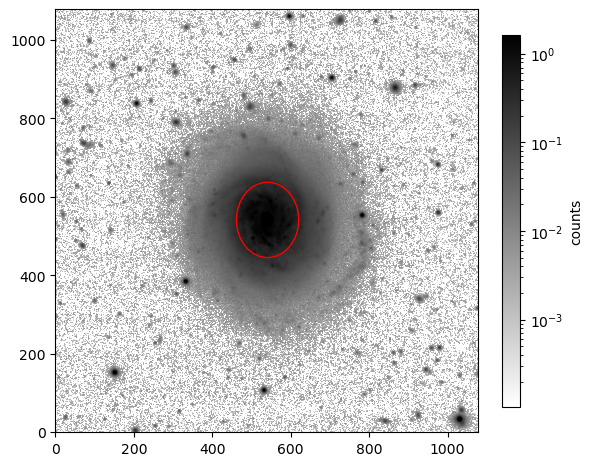

In [30]:
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC3982'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
aper.plot(color='red')

### NGC 5198

0.0009398460388183594 10.000036239624023


(<matplotlib.patches.Ellipse at 0x7f392fac3340>,)

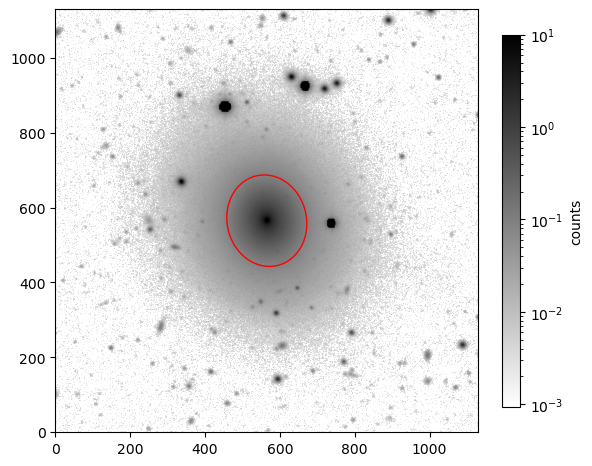

In [31]:
#***************************
#Your code here
#set up the EllipseGeometry instance with the right initial guess parameters
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5198'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
aper.plot(color='red')

### NGC 5985

0.0002899169921875 10.000089645385742


(<matplotlib.patches.Ellipse at 0x7f392cf498d0>,)

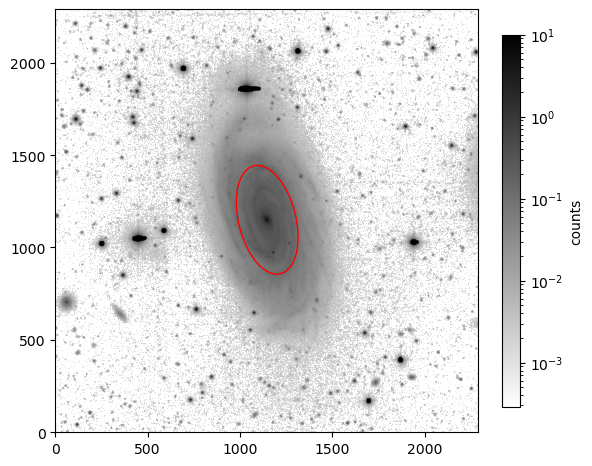

In [32]:
#***************************
#Your code here
#set up the EllipseGeometry instance with the right initial guess parameters
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5985'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
aper.plot(color='red')

### PGC 0997820

0.0004949569702148438 0.6742499732971232


(<matplotlib.patches.Ellipse at 0x7f392f404280>,)

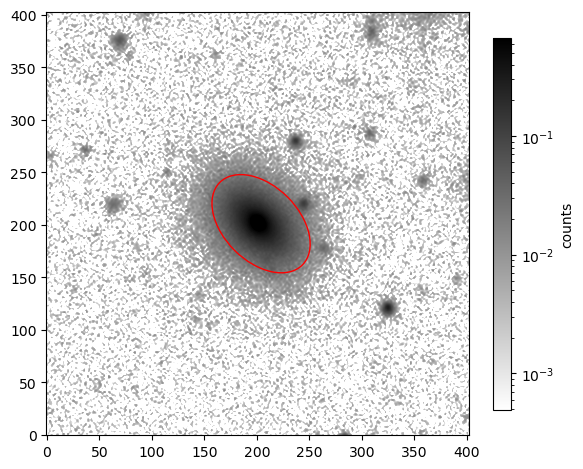

In [33]:
#***************************
#Your code here
#set up the EllipseGeometry instance with the right initial guess parameters
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'PGC099782'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=50,v2perc=99.9,logscale=True)
aper.plot(color='red')

make a subroutine to plot our outputs of ellipse fitting

In [34]:
def plotellipse(isolist):
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.35, wspace=0.35)

    #plot the semi-major axis vs. the ellipticity
    plt.subplot(2, 2, 1)
    plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
                 fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('Ellipticity')

    #plot the semi-major axis vs. the PA
    plt.subplot(2, 2, 2)
    plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.0,
                 yerr=isolist.pa_err / np.pi * 80.0, fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('PA (deg)')

    #plot the semi-major axis vs. the x center of that ellipse
    plt.subplot(2, 2, 3)
    plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('x0')

    #plot the semi-major axis vs. the y center of that ellipse
    plt.subplot(2, 2, 4)
    plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('y0')

Next, we create an instance of the Ellipse class, inputting the data to be fitted and the initial ellipse geometry object:

In [35]:
from photutils.isophote import Ellipse

#initialize dictionary for ellipse fitting
ellipse = {}
isolist = {}

The values computed by the fitting process are the attributes at this table https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Isophote.html#photutils.isophote.Isophote

I will do the first galaxy for you and you will need to do the other three

### NGC 3982

In [36]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC3982'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

/home/d420h138/.conda/envs/env1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/d420h138/.conda/envs/env1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/d420h138/.conda/envs/env1/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/d420h138/.conda/envs/env1/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/d420h138/.conda/envs/env1/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


       sma                 intens        ... niter stop_code
                                         ...                
------------------ --------------------- ... ----- ---------
               0.0    13.573973832708088 ...     0         0
  0.50777761257742    13.419052133944023 ...    10         0
0.5585553738351621    13.396707576074553 ...    10         0
0.6144109112186783    13.371824381843474 ...    10         0
0.6758520023405461    13.318861917974205 ...    11         0
0.7434372025746008    13.200099101565282 ...    10         0
               ...                   ... ...   ...       ...
154.60896000000005   0.06405788114588475 ...    10         0
170.06985600000007  0.040546572876057896 ...    50         2
 187.0768416000001  0.024230536040486795 ...    50         2
205.78452576000012  0.016461194198255088 ...    50         2
226.36297833600014  0.011110543861178473 ...    50         2
248.99927616960017 0.0075742564734458204 ...    15         5
 273.8992037865602  0.00

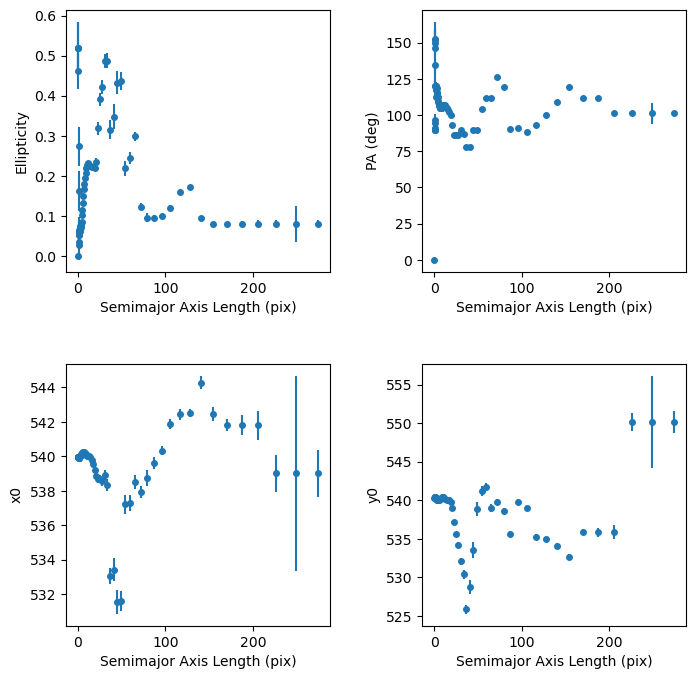

In [37]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

**put answer in this cell**

The elipticity is very erratic at the center, which makes sense because there are a lot of material in the center that can make it hard to effectively calculate the eplipticity. As for the other plots the PA seems to be somewhat stable all throughout, while the x0 and y0 has a dropoff before climbing up again.

### NGC 5198

In [38]:
#***************************
#Your code here
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC5198'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0   17.017519662193347 ...     0         0
0.5376777405907598    16.82795719094149 ...    11         0
0.5914455146498357    16.80215098315133 ...    11         0
0.6505900661148193   16.772296681263846 ...    11         0
0.7156490727263012   16.717170868481325 ...    10         0
0.7872139799989313   16.621013798931525 ...    10         0
               ...                  ... ...   ...       ...
            148.83 0.057247197766937416 ...    10         0
163.71300000000002  0.04659176700348497 ...    10         0
180.08430000000004  0.03816061362650925 ...    50         2
198.09273000000007  0.03153024860315039 ...    50         2
 217.9020030000001 0.023069078060846942 ...    50         2
239.69220330000013 0.017834114555201546 ...    11         5
 263.6614236300002  0.01280771565522187 

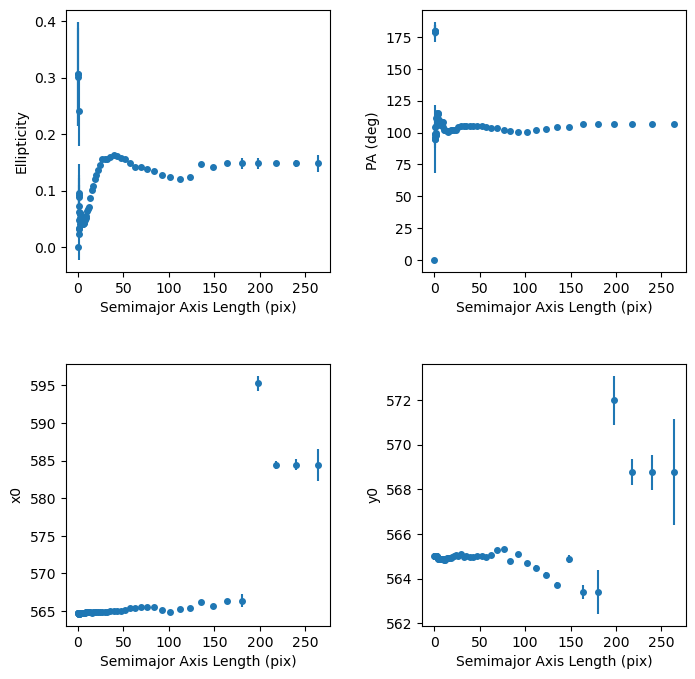

In [39]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

**put answer in this cell**
The plots behavior are quite consistent, which makes sense because this seems to be an eliptical galaxy with little variance within the galaxy itself.

### NGC 5985

In [40]:
#***************************
#Your code here
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC5985'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0    6.427170613607523 ...     0         0
0.5072903371778887    6.338472621712322 ...    10         0
0.5580193708956777    6.325840055605557 ...    10         0
0.6138213079852455    6.311934102771772 ...    10         0
0.6752034387837701    6.296717077808821 ...    10         0
0.7427237826621471    6.279962085848019 ...    10         0
               ...                  ... ...   ...       ...
 440.6941000000001  0.03624376536465548 ...    10         0
484.76351000000017    0.024950019654678 ...    50         2
 533.2398610000002 0.018055929369344723 ...    50         2
 586.5638471000003 0.011673629116231543 ...    50         2
 645.2202318100004 0.017339794417852855 ...    23         0
 709.7422549910006 0.009729501854986378 ...     7         5
 780.7164804901007 0.005079116380321665 

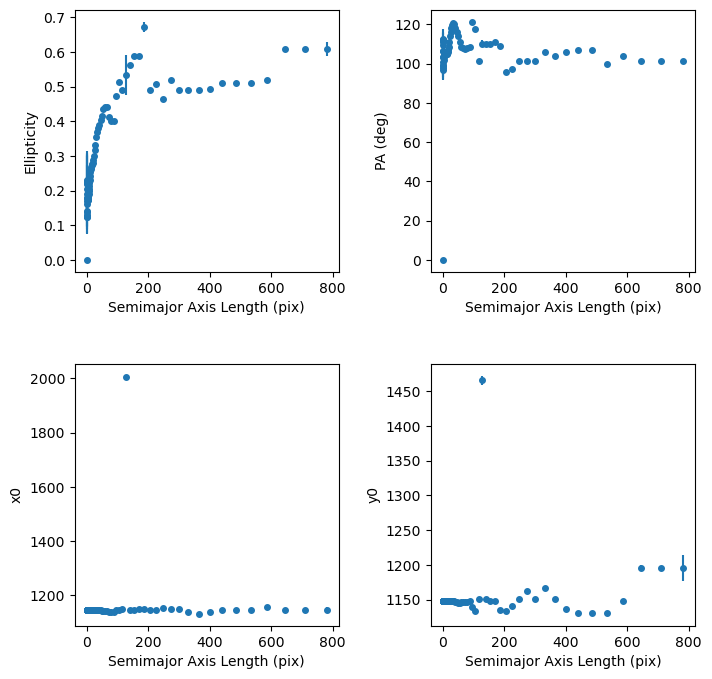

In [41]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

**put answer in this cell**

There is an outlier contour at ~180pix semimajor axis length that seems to bias my results. Which makes it hard to ascertain the behavior of my galaxy in detail. However, both the elipticity and the PA are somewhat stable outside of the eclipse center.

### PGC 0997820

In [42]:
#***************************
#Your code here
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'PGC099782'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                 intens        ... niter stop_code
                                         ...                
------------------ --------------------- ... ----- ---------
               0.0     1.356514547822203 ...     0         0
0.5209945962542584    1.3468244617416405 ...    13         0
0.5730940558796842    1.3452588937583545 ...    11         0
0.6304034614676527    1.3435488239151208 ...    10         0
0.6934438076144179    1.3409270978734336 ...    10         0
0.7627881883758597    1.3390522466906931 ...    10         0
               ...                   ... ...   ...       ...
61.160000000000004  0.014613853132111875 ...    11         0
 67.27600000000001  0.009752157708803392 ...    50         2
 74.00360000000002    0.0077070940582244 ...    32         0
 81.40396000000003  0.003516621887917286 ...    50         2
 89.54435600000004   0.00207601885748227 ...    50         2
 98.49879160000005 0.0015143612588193384 ...     4         5
108.34867076000006 0.002

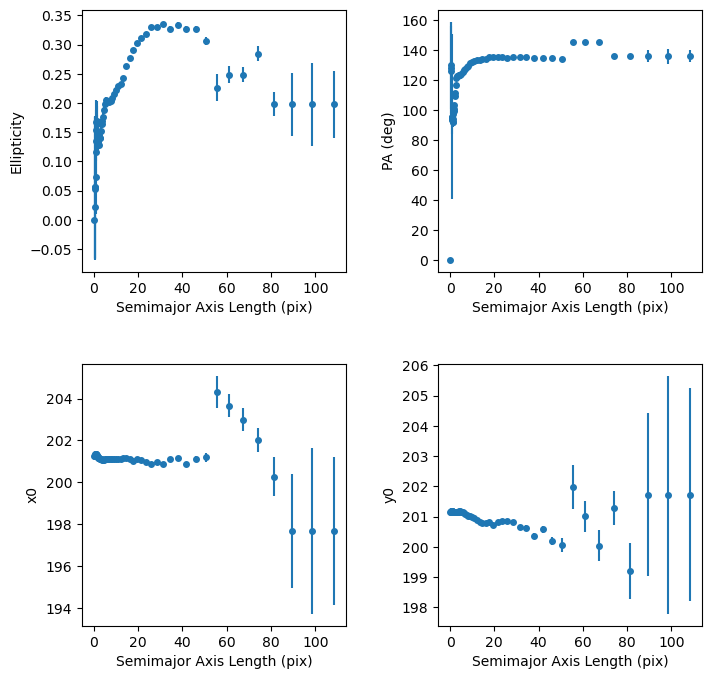

In [43]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

**put answer in this cell**

While this galaxy plots have a stable behavior near the center, the further it is from the axis, the more erratic the behavior is. Possibly because the resolution of this galaxy isn't as good as the other 3

## Problem 4 - measure the half light radius (15 points)

To do this we will create something called a "curve of growth", which shows how much light you get within each aperture.  As you increase in radius this cumulative flux grows.



In [44]:
#initialize dictionary for half-light radii
rhalfpix = {}
rhalfasec = {}

### NGC 3982

flux of largest isophote =  29369.822265625


Text(0.5, 1.0, 'NGC3982')

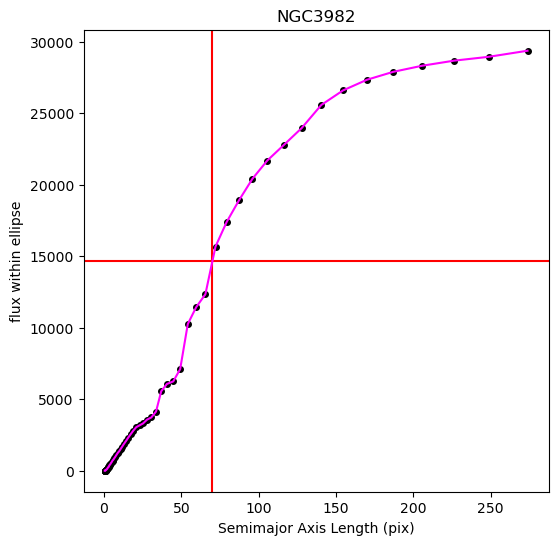

In [45]:
galname = 'NGC3982'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 70
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 60*60

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname] * pixscale

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


### NGC 5198

flux of largest isophote =  25732.251953125


Text(0.5, 1.0, 'NGC5198')

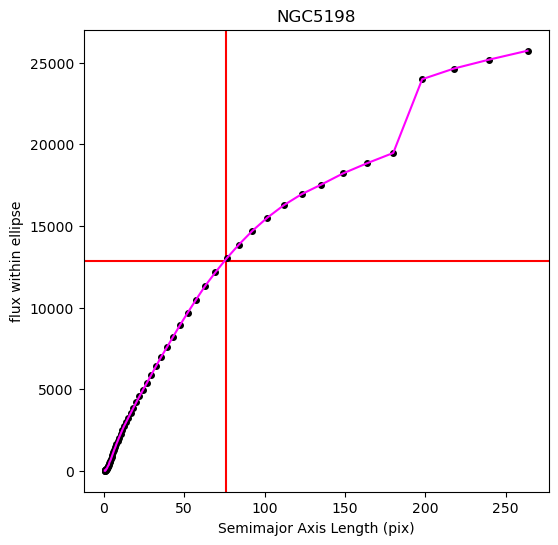

In [50]:
galname = 'NGC5198'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 76
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 60*60

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname] * pixscale

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


### NGC 5985

flux of largest isophote =  75820.2265625


Text(0.5, 1.0, 'NGC5985')

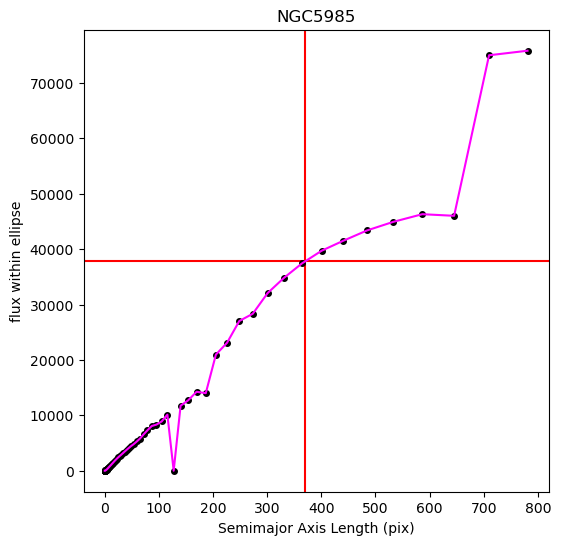

In [52]:
galname = 'NGC5985'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 370
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 60*60

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname] * pixscale

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


### PGC 0997820

flux of largest isophote =  920.6477661132812


Text(0.5, 1.0, 'PGC099782')

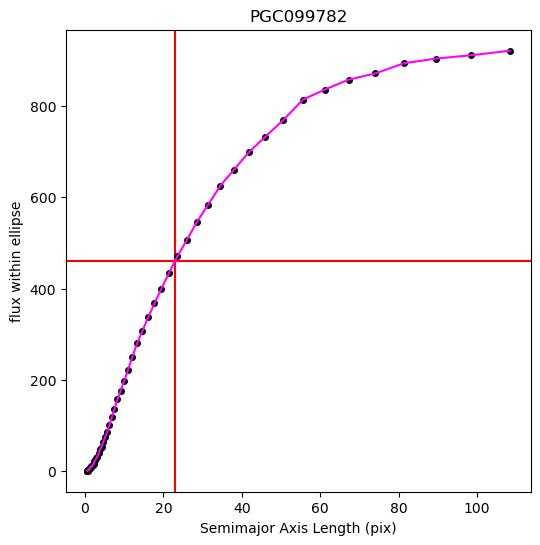

In [53]:
galname = 'PGC099782'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 23
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 60*60

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname] * pixscale

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


**Question** For the galaxies above, answer in words written below each bullet:
* For each galaxy how the half-light compares to the visible extent of the galaxy using what you see in the displayed images or in ds9?
* NGC 3982 - The half-light covers much of the core of the galaxy
* NGC 5198 - The half-light stretchs out to about to a little over the core of the galaxy
* NGC 5985 - There is an anormality in the light curve with both a value too small at ~140pix, and 2 very large values at the tail end, but overall, the half-light seems to stretch out to much of the inner spiral
* PGC 0997820 - The half-light is centered in the core, with a rapid drop-off the further you get from the bulge
* For each galaxy, which feature of the curve of growth tells you whether you can establish well what the maximum flux is?
* Barring any anormalies, all the flux curves seems to asymptote at some value once you go further away from the center. WHich can help us establish a maximum flux
* For each galaxy, use imexam to measure the FWHM of the image using stars in the image.  Then quantify how your half-light radius for each galaxy compares to the FWHM.
* NGC 3982 - imexam FWHM 4.53
* NGC 5198 - imexam FWHM 9.07
* NGC 5985 - imexam FWHM 53.38
* PGC 0997820 - imexam FWHM 6.12
* All of the half-light radius are larger than the imexam FWHM, which makes sense because we are comparing the half-light of a galaxy compared to the FWHM of stars within the image. Furthermore, higher resolution images yields higher FWMH, which also makes the half-light radius of the galaxy bigger.

**Question** If the goal of measuring the half-light radius is to obtain light from the galaxy.  What do you think you can do in order to minimize the effect of other sources in the image on this measurment.
* I can manually try to exclude stars and other things that just happens to be within the area I'm examinging, but isn't part of the galaxy itself. Also, I could try to fit a better shape to the galaxy instead of just a standard elipse.

**put answer here**


## Problem 5 - construct radial surface brightness profiles (15 Points)

In this problem you will construct radial surface brightness profiles of each galaxy and use them to infer the central surface brightness and that at the half-light radius.

For the purpose of these plots, we will fix the ellipticity and position angle at the values determined at the half-light radius.

You will need to:
* measure mean surface brightness in mag/asec^2 in each annulus
* calculate its uncertainty
* plot the surface brightness profile
* determine the surface brightness at the half-light radius

In [54]:
from photutils.aperture import ApertureStats
from photutils.aperture import EllipticalAnnulus, EllipticalAperture

### NGC 3982

r = 2.3214289461495183 [asec]; surface brightness at r = 17.44853575186488
r = 20.786776859504137 [asec]; surface brightness at r = 19.524491648477422
flux_SB(rhalf) / flux_SB(rcent) = 0.147780673452785


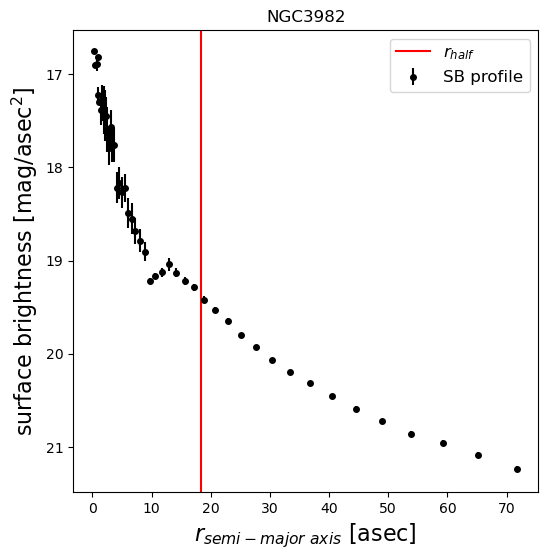

In [55]:
galname = 'NGC3982'

#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area
        
        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale*pixscale
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent, -2.5 * np.log10(avflux/pixarea) + magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = stdflux/np.sqrt(numpix)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, 1.086 * (avflux_err/avflux))

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
print('r =', rcent[30], '[asec]; surface brightness at r =', sbcent[30])

#calculate print out the surface brightness at the effective radius
#***********************
#your code here
print('r =', rcent[rhalfpixind], '[asec]; surface brightness at r =', sbcent[rhalfpixind])

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = 10**(-0.4 * (sbcent[rhalfpixind] - sbcent[30]))
print('flux_SB(rhalf) / flux_SB(rcent) =', flux_rat)

### NGC 5198

r = 2.458124658887661 [asec]; surface brightness at r = 17.445695079457217
r = 22.010791612594772 [asec]; surface brightness at r = 19.81186133126183
flux_SB(rhalf) / flux_SB(rcent) = 0.11311846398262614


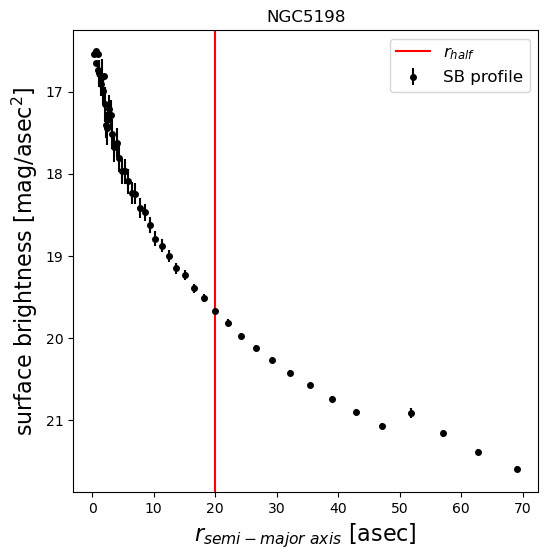

In [56]:
galname = 'NGC5198'
#***************
# your code goes here

#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area
        
        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale*pixscale
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent, -2.5 * np.log10(avflux/pixarea) + magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = stdflux/np.sqrt(numpix)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, 1.086 * (avflux_err/avflux))

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
print('r =', rcent[30], '[asec]; surface brightness at r =', sbcent[30])

#calculate print out the surface brightness at the effective radius
#***********************
#your code here
print('r =', rcent[rhalfpixind], '[asec]; surface brightness at r =', sbcent[rhalfpixind])

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = 10**(-0.4 * (sbcent[rhalfpixind] - sbcent[30]))
print('flux_SB(rhalf) / flux_SB(rcent) =', flux_rat)

### NGC 5985

r = 2.319201248060435 [asec]; surface brightness at r = 18.313314747520415
r = 104.96532200000004 [asec]; surface brightness at r = 22.699179946281305
flux_SB(rhalf) / flux_SB(rcent) = 0.017605725266220482


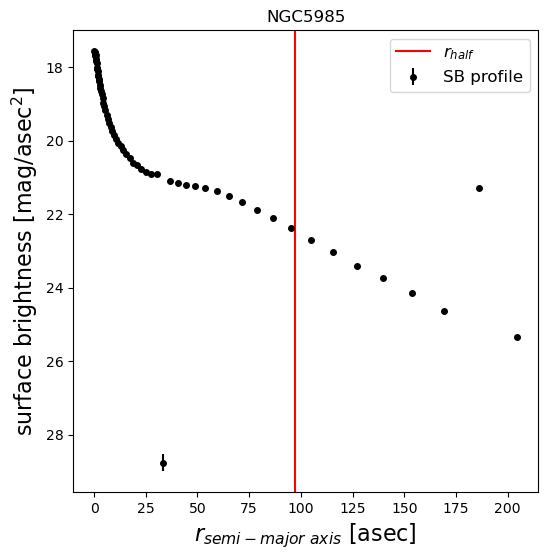

In [57]:
galname = 'NGC5985'

#***************
# your code goes here
#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area
        
        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale*pixscale
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent, -2.5 * np.log10(avflux/pixarea) + magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = stdflux/np.sqrt(numpix)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, 1.086 * (avflux_err/avflux))

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
print('r =', rcent[30], '[asec]; surface brightness at r =', sbcent[30])

#calculate print out the surface brightness at the effective radius
#***********************
#your code here
print('r =', rcent[rhalfpixind], '[asec]; surface brightness at r =', sbcent[rhalfpixind])

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = 10**(-0.4 * (sbcent[rhalfpixind] - sbcent[30]))
print('flux_SB(rhalf) / flux_SB(rcent) =', flux_rat)

### PGC 0997820

r = 2.381853603968636 [asec]; surface brightness at r = 19.739152842822605
r = 6.795706308991229 [asec]; surface brightness at r = 20.967509393965084
flux_SB(rhalf) / flux_SB(rcent) = 0.322594812593101


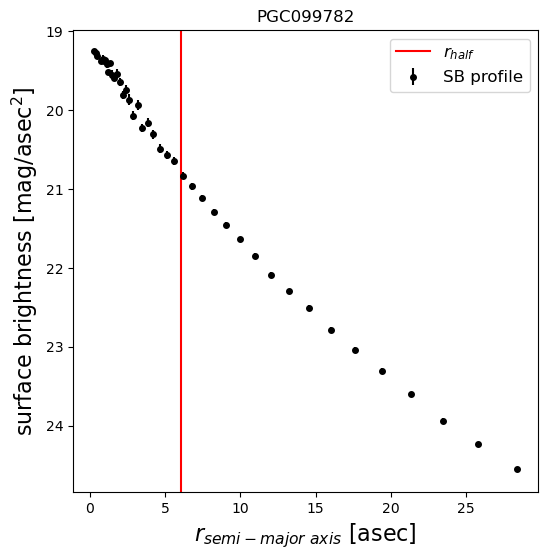

In [59]:
galname = 'PGC099782'

#***************
# your code goes here

#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area
        
        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale*pixscale
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent, -2.5 * np.log10(avflux/pixarea) + magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = stdflux/np.sqrt(numpix)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, 1.086 * (avflux_err/avflux))

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
print('r =', rcent[30], '[asec]; surface brightness at r =', sbcent[30])

#calculate print out the surface brightness at the effective radius
#***********************
#your code here
print('r =', rcent[rhalfpixind], '[asec]; surface brightness at r =', sbcent[rhalfpixind])

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = 10**(-0.4 * (sbcent[rhalfpixind] - sbcent[30]))
print('flux_SB(rhalf) / flux_SB(rcent) =', flux_rat)

**Question** Describe the ratio in surface brightness between the center and outskirts including the following points:
* Are there differences between ellipticals and spirals?
* Does the degree to which your galaxy is well resolved matter?
* Does the behavior of the light profile differ inside and outside of the half-light radius?  
* which galaxies have light profiles consistent with being exponential, and in what part of the profiles

**answer goes here**
* Spirals have a steeper dropoff near the center, then it does so more gradually in the outer regions. While ellipticals have a consistent dropoff that doesn't appear to change too much.
* It does not seem to matter too much, but being well-resolved helps us better understand whenever a galaxy is a spiral or an eliptical by better characterizing the behaviour near the center, and whenever a part of an image is actually part of the galaxy or not.
* For the spiral galaxies, the behaviour within the half-light radius often has a steeper dropoff, and then more gradual outside of it. While for ellipticals, they don't seem to have too much of an impact.
* The spiral galaxies NGC 3982 and NGC 5985 seems to have an exponential dropoff before the half-light radius, and then turns more gradual outside of it.